In [1]:
import os
import math
import json
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

In [2]:
Data_Root = '/Data/Promotion/'

In [3]:
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}

In [4]:
gens = ['Male', 'Female']
labels = ['Man', 'Woman']

In [5]:
colors = sns.color_palette()[:len(labels)]

In [6]:
reg_data = pd.read_csv(Data_Root+"revision/reg_data_drop_missing.csv", header=0, dtype={'matched_tid': str, 'matched_tid_retweet': str, 'matched_tid_original': str})


In [7]:
len(reg_data)

14552304

Exclude unknown affiliation locations

In [8]:
len(reg_data.loc[reg_data.affiliation_cate == 'unknown'])

30719

In [9]:
reg_data = reg_data.loc[reg_data.affiliation_cate != 'unknown']
reg_data.index = range(len(reg_data))

In [10]:
len(reg_data)

14521585

In [11]:
len(set(reg_data.doi))

2983706

In [12]:
reg_data.head(n=3)

,doi,pub_year,author_name,authorship_seq,authorship_pos,author_id,affiliation_ids,self_promotion_original,matched_tid_original,self_promotion_retweet,...,matched_uid,is_active_on_twitter_ours,follower_cn_snapshot_ours,is_active_on_twitter_combine,follower_cn_snapshot_combine,self_promotion_first,matched_tid_retweet_cn,matched_tid_likes_cn,aut_first_pub_year,affiliation_country
0,10.4202/app.00261.2016,2016,Michal Zaton,2,last_position,2064717215,864159182,False,NaN,False,...,NaN,False,-1,False,-1,False,0,0,2003,Poland
1,10.1016/j.foodchem.2013.11.152,2014,Hee-Woong Kim,2,middle_position,2099457132,165507594,False,NaN,False,...,NaN,False,-1,False,-1,False,0,0,2008,"Korea, Republic of"
2,10.1016/j.foodchem.2013.11.152,2014,Deug-Chan Lee,4,middle_position,2322741405,165507594,False,NaN,False,...,NaN,False,-1,False,-1,False,0,0,1997,"Korea, Republic of"


In [36]:
reg_data.gender.value_counts()

Male       7371102
Female     4025650
Unknown    2316513
Unisex      808320
Name: gender, dtype: int64

In [37]:
# authorship gender dist.
reg_data.gender.value_counts()/len(reg_data)

Male       0.507596
Female     0.277218
Unknown    0.159522
Unisex     0.055663
Name: gender, dtype: float64

In [38]:
tem = dict(Counter(dict(zip(reg_data['author_id'], reg_data['gender'])).values()))

In [43]:
# author gender dist.
for gen in tem:
    print(gen, tem[gen]/ sum(tem.values()))

Male 0.42855114504677255
Unknown 0.19283816305216323
Female 0.313597969640859
Unisex 0.06501272226020523


Exclude unisex and unknown

In [13]:
reg_data = reg_data.loc[reg_data['gender'].isin(['Female', 'Male'])]
reg_data.index = range(len(reg_data))

In [14]:
len(reg_data)

11396752

In [50]:
len(set(reg_data.author_id))

3503674

In [47]:
dois_ = set(reg_data.doi)

In [48]:
len(dois_)

2834829

In [40]:
i = 0

with open(Data_Root+'revision/papers_2013_2018.json', 'r') as ifile:
    for line in ifile:
        res = json.loads(line)
        if res['doi'] in dois_:
            i += len(res['data']['tweets'])

In [41]:
# total num of tweet mentions
print(i)

23066929


### (paper, author) level

In [52]:
reg_data.gender.value_counts()/len(reg_data)

Male      0.646772
Female    0.353228
Name: gender, dtype: float64

In [53]:
np.mean(reg_data.self_promotion)

0.042171839836472706

In [54]:
for gender, group in reg_data.groupby('gender'):
    print(gender, np.mean(group.self_promotion))

Female 0.03473749580813036
Male 0.04623202880654752


Author position

In [46]:
name_pos = {'first_position': 'First Position', 'middle_position': 'Middle Position', 'last_position': 'Last Position'}


In [50]:
means = [[], []]
confs = [[], []]
aut_pos = []
for pos, subgp in reg_data.groupby('authorship_pos'):
    if pos != 'solo_author':
        aut_pos.append(pos)
        for i, gen in enumerate(gens):
            gp = subgp.loc[subgp.gender==gen]
            means[i].append(np.mean(gp['self_promotion']) * 100)
            sigma = np.std(gp['self_promotion']) * 100
            confs[i].append(CIs['95']*(sigma/np.sqrt(len(gp))))

In [51]:
means

[[7.464804377192448, 5.846980253665916, 3.4033408154695035],
 [5.8880009036739995, 4.982378943618129, 2.2634595327906073]]

In [52]:
for i in range(3):
    a = means[0][i]
    b = means[1][i]
    print((a-b)/b)

0.2677994618741572
0.17353182482340984
0.5036013527812192


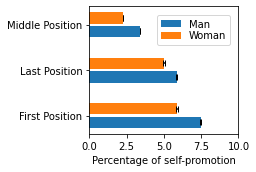

In [53]:
step = 4
ys_1 = 0.9 + np.arange(3) * step
ys_2 = 2.1 + np.arange(3) * step
y_pos = 1.5 + np.arange(3) * step

fig, ax = plt.subplots(figsize = (3.6, 2.5))

ax.barh(ys_1, width = means[0], height=1, xerr = confs[0], alpha = 1.0, capsize = 3, color=colors[0], label='Man')
ax.barh(ys_2, width = means[1], height=1, xerr = confs[1], alpha = 1.0, capsize = 3, color=colors[1], label='Woman')

legend = ax.legend(loc=[0.45, 0.7], numpoints=1, labelspacing = 0.15, shadow=False, frameon = True)
ax.set_yticks(y_pos)
ax.set_yticklabels([name_pos[pos] for pos in aut_pos], rotation=0, ha='right')
ax.set_xlabel('Percentage of self-promotion')
ax.set_xlim([0, 10])
plt.tight_layout()
plt.show()
fig.savefig('./perc_promo_gender_pos.pdf', bbox_inches='tight', pad_inches=0.02)


Discipline

In [54]:
name_map = {'Social Sciences': 'Social_Sciences',
            'Life Sciences': 'Life_Sciences',
            'Health Sciences': 'Health_Sciences',
            'Physical Sciences': 'Physical_Sciences'}

In [55]:
for disc in name_map.values():
    sub_df = reg_data.loc[reg_data[disc] == 1]
    print(disc, np.mean(sub_df.self_promotion))

Social_Sciences 0.07824941768713913
Life_Sciences 0.03554151987445492
Health_Sciences 0.03386756643618453
Physical_Sciences 0.03339868393109221


In [56]:
means = [[], []]
confs = [[], []]
for disc in name_map:
    subgp = reg_data.loc[reg_data[name_map[disc]] == 1]
    for i, gen in enumerate(gens):
        gp = subgp.loc[subgp.gender==gen]
        means[i].append(np.mean(gp['self_promotion']) * 100)
        sigma = np.std(gp['self_promotion']) * 100
        confs[i].append(CIs['95']*(sigma/np.sqrt(len(gp))))

In [57]:
means

[[8.396830631443747, 4.170143540968367, 3.747922218847165, 3.456138624438304],
 [7.056924497900696,
  2.5407740739434024,
  2.8196011668102687,
  3.0057598930586407]]

In [58]:
for i in range(4):
    a = means[0][i]
    b = means[1][i]
    print((a-b)/b)

0.18987111650998215
0.6412886071747835
0.32923842668396897
0.14983855910106011


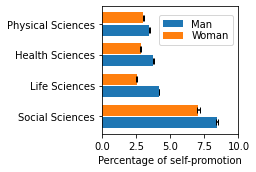

In [59]:
step = 2.5
ys_1 = 1 + np.arange(4) * step
ys_2 = 2 + np.arange(4) * step
y_pos = 1.5 + np.arange(4) * step

fig, ax = plt.subplots(figsize = (3.6, 2.5))

ax.barh(ys_1, width = means[0], height=0.9, xerr = confs[0], alpha = 1.0, capsize = 3, color=colors[0], label='Man')
ax.barh(ys_2, width = means[1], height=0.9, xerr = confs[1], alpha = 1.0, capsize = 3, color=colors[1], label='Woman')

legend = ax.legend(loc=[0.42, 0.7], numpoints=1, labelspacing = 0.15, shadow=False, frameon = True)
ax.set_yticks(y_pos)
ax.set_yticklabels([disc for disc in name_map], rotation=0, ha='right')
ax.set_xlabel('Percentage of self-promotion')
ax.set_xlim([0, 10])
plt.tight_layout()
plt.show()
fig.savefig('./perc_promo_gender_disc.pdf', bbox_inches='tight', pad_inches=0.02)

By year

In [60]:
gender_y_rate = {'Male': {}, 'Female': {}}

for gender in gens:
    tem = reg_data.loc[reg_data.gender==gender, ['pub_year', 'self_promotion']]
    for year, sub_df in tem.groupby('pub_year'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_y_rate[gender][year] = (mu, std, n)

In [61]:
gender_y_rate

{'Male': {2013: (0.02017481037794199, 0.14059796372691913, 983008),
  2014: (0.026914707181600273, 0.16183419205757782, 1104712),
  2015: (0.03575409338209638, 0.18567643412269833, 1238096),
  2016: (0.04390702576006032, 0.20488825942197314, 1320882),
  2017: (0.058158548230234114, 0.23404301206826417, 1358287),
  2018: (0.08048871363140932, 0.27204830565429056, 1366117)},
 'Female': {2013: (0.01220630626977829, 0.10980579382266972, 517929),
  2014: (0.017476197835128434, 0.13103732424143846, 595324),
  2015: (0.02447975462428289, 0.15453315578806312, 691837),
  2016: (0.031770222585426736, 0.17538778618335768, 742771),
  2017: (0.045048333352957104, 0.2074101757751484, 764379),
  2018: (0.06748854095120618, 0.2508661750644824, 713410)}}

In [62]:
for y in list(range(2013, 2019)):
    a = gender_y_rate['Male'][y][0]
    b = gender_y_rate['Female'][y][0]
    print(y, (a-b)/b)

2013 0.6528186276869847
2014 0.5400779640694926
2015 0.4605576702402819
2016 0.382018197763614
2017 0.2910255252854192
2018 0.19262785203197952


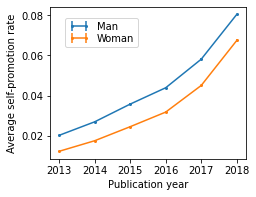

In [63]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

for i, lab, gender, color in zip(range(len(labels)), labels, gens, colors):
    xs = list(range(2013, 2019))
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_y_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=lab)

legend = ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
ax.set_xlabel('Publication year')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_year_raw.pdf', bbox_inches='tight', pad_inches=0.01)


In [52]:
for year, gp in reg_data.loc[reg_data['is_active_on_twitter'] == True].groupby('pub_year'):
    print(year, np.mean(gp['self_promotion']))

2013 0.354429876837505
2014 0.369352674292287
2015 0.3842091705306543
2016 0.39092126212187
2017 0.4341819550792936
2018 0.477156755210072


By journal impact

In [64]:
gender_jif_rate = {'Male': {}, 'Female': {}}

for gender in gens:
    tem = reg_data.loc[reg_data.gender==gender, ['journal_impact', 'self_promotion']]
    # tem = tem.dropna()
    tem['jif_bin'] = tem['journal_impact'].apply(lambda x: int(x//5))
    tem['jif_bin'] = tem['jif_bin'].apply(lambda x: x if x <= 8 else 9)
    for jif, sub_df in tem.groupby('jif_bin'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_jif_rate[gender][jif] = (mu, std, n)

In [65]:
gender_jif_rate

{'Male': {0: (0.03960319826621017, 0.19502508800997237, 5027599),
  1: (0.047001103303449844, 0.21164120485318616, 1594303),
  2: (0.07634592943684901, 0.26555080209871834, 347065),
  3: (0.06374213661415132, 0.24429301388704136, 125741),
  4: (0.09832948526415863, 0.2977596305610354, 66267),
  5: (0.059756388280301054, 0.23703493907016102, 88091),
  6: (0.09879891514916699, 0.29839183888725024, 15486),
  7: (0.12523350234455416, 0.33098349239058844, 26231),
  8: (0.18241516399261679, 0.38618631764753586, 56344),
  9: (0.223274244004171, 0.4164406992220344, 23975)},
 'Female': {0: (0.03268474301229658, 0.17781015321549196, 2888932),
  1: (0.033202761158268125, 0.17916567140424838, 778369),
  2: (0.049151412292399076, 0.21618406731778753, 164980),
  3: (0.03747859824387792, 0.18993144267748802, 63663),
  4: (0.07107818261781522, 0.25695539413206275, 29559),
  5: (0.03029492271913396, 0.1713976090165078, 48589),
  6: (0.06954397394136808, 0.25437690467062923, 6140),
  7: (0.0669930640554

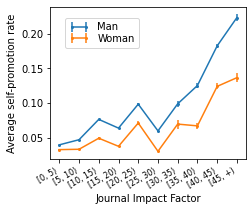

In [66]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

for i, lab, gender, color in zip(range(len(labels)), labels, gens, colors):
    xs = list(range(10))
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_jif_rate[gender][j]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=lab)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
# ax.margins(0,0)
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)', '[30, 35)', '[35, 40)', \
                    '[40, 45)', '[45, +)'])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(30)
ax.set_xlabel('Journal Impact Factor')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_jif_raw.pdf', bbox_inches='tight', pad_inches=0.01)

By affiliation rank

In [15]:
gender_affi_rate = {'Male': {}, 'Female': {}}

for gender in gens:
    tem = reg_data.loc[reg_data.gender==gender, ['affiliation_rank_cate', 'self_promotion']]
    # tem = tem.dropna()
    # tem['affi_bin'] = tem['affiliation_rank'].apply(lambda x: int(x//2000))
    for affi, sub_df in tem.groupby('affiliation_rank_cate'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_affi_rate[gender][affi] = (mu, std, n)

In [16]:
gender_affi_rate

{'Male': {0.0: (0.06192244403896991, 0.24101463640868484, 781526),
  1.0: (0.05633711964928807, 0.2305715693638526, 821643),
  2.0: (0.04469021075738475, 0.20662283470092377, 800399),
  3.0: (0.05011821425723113, 0.21818886052431138, 777402),
  4.0: (0.04272879730125758, 0.202245017694987, 774583),
  5.0: (0.04520512940284277, 0.20775376212842697, 727882),
  6.0: (0.03938829542891983, 0.19451698540776324, 718386),
  7.0: (0.034215424479932414, 0.18178209264828712, 669961),
  8.0: (0.039655973393470816, 0.19514962763911992, 650066),
  9.0: (0.04369168307010816, 0.20440821876971918, 649254)},
 'Female': {0.0: (0.04304108082189849, 0.20294961488897015, 425454),
  1.0: (0.045412259161314694, 0.2082065942259761, 423520),
  2.0: (0.034949681870623577, 0.1836523934169272, 437715),
  3.0: (0.04211136486896641, 0.2008432170072945, 401958),
  4.0: (0.031871037855460964, 0.17565669586291535, 414075),
  5.0: (0.03377488708579492, 0.18064922941473274, 402518),
  6.0: (0.030451883276368445, 0.171827

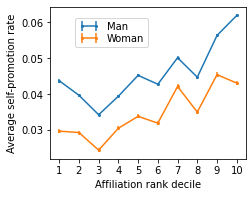

In [26]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

xs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for i, lab, gender, color in zip(range(len(labels)), labels, gens, colors):
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_affi_rate[gender][j-1]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(np.array(xs)*-1+11, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=lab)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.1, 0.7), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
# ax.margins(0,0)
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticks(xs)
# ax.set_xticklabels(list(range(1, 11)))
# for tick in ax.get_xticklabels():
#     tick.set_ha('right')
#     tick.set_fontsize(8)
#     tick.set_rotation(30)
ax.set_xlabel('Affiliation rank decile')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_affi_raw.pdf', bbox_inches='tight', pad_inches=0.01)


By previous num. publications

In [18]:
gender_pub_rate = {'Male': {}, 'Female': {}}

for gender in gens:
    tem = reg_data.loc[reg_data.gender==gender, ['author_pub_count_cate', 'self_promotion']]
    # tem = tem.dropna()
    # tem['pub_bin'] = tem['author_pub_count'].apply(lambda x: int(x//10))
    for pub, sub_df in tem.groupby('author_pub_count_cate'):
        mu = np.mean(sub_df['self_promotion'])
        std = np.std(sub_df['self_promotion'])
        n = len(sub_df)
        gender_pub_rate[gender][pub] = (mu, std, n)

In [19]:
gender_pub_rate

{'Male': {0.0: (0.02420530476792262, 0.15368606959973502, 401978),
  1.0: (0.034062262481360704, 0.18138915280691842, 448649),
  2.0: (0.04053287919814202, 0.19720538760908854, 456839),
  3.0: (0.04683624344327082, 0.21128797822733197, 695850),
  4.0: (0.052593923688379784, 0.22322142119304023, 658327),
  5.0: (0.05555466330301185, 0.2290596924129185, 809437),
  6.0: (0.05483019691410214, 0.22764851508512615, 838589),
  7.0: (0.0511002828613892, 0.2202022796268813, 917764),
  8.0: (0.04626174606913726, 0.2100514149435131, 1010338),
  9.0: (0.04010390609627726, 0.19620291234356907, 1133331)},
 'Female': {0.0: (0.017285923765041778, 0.13033464851922894, 386673),
  1.0: (0.024666470102876002, 0.15510652905516237, 437517),
  2.0: (0.029919444883719816, 0.17036511292389023, 417354),
  3.0: (0.03534322574963674, 0.1846458289354162, 567775),
  4.0: (0.04090790955557481, 0.1980768853030755, 461720),
  5.0: (0.043678804274593946, 0.20437946651201447, 482385),
  6.0: (0.04242458068022985, 0.2015

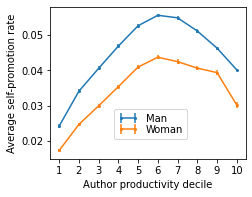

In [23]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))

# xs = np.arange(0, 101, 10)
xs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for i, lab, gender, color in zip(range(len(labels)), labels, gens, colors):
    ys = []
    confs = []
    for j in xs:
        mu, std, n = gender_pub_rate[gender][j-1]
        ys.append(mu)
        confs.append(CIs['95'] * std / np.sqrt(n))
    ax.errorbar(xs, ys, yerr=confs, color=color, alpha=1, fmt='-o', markersize=2, linewidth=1.5, label=lab)
    
# ax.legend(bbox_to_anchor=(1, -0.03), loc='lower left', labelspacing = 1.05, frameon = True)
legend = ax.legend(bbox_to_anchor=(0.3, 0.1), loc='lower left', numpoints=2, labelspacing = 0.15, shadow=False, frameon = True, markerscale = 1)
ax.set_xticks(xs)
# ax.set_xticklabels([1, 3, 6, 13, 23, 41, 69, 118, 229, 4871])
# for tick in ax.get_xticklabels():
#     tick.set_ha('right')
#     tick.set_fontsize(8)
#     tick.set_rotation(20)
ax.set_xlabel('Author productivity decile')
ax.set_ylabel('Average self-promotion rate')

# plt.tight_layout()
plt.show()
fig.savefig('./gender_pub_raw.pdf', bbox_inches='tight', pad_inches=0.01)


Geographic distribution (% in active subset)

In [19]:
reg_data['affiliation_country'].value_counts()[:10]

United States     3964712
United Kingdom    1008211
Germany            614149
Australia          575758
China              457319
Canada             449088
Japan              400034
France             387454
Italy              359034
Netherlands        313734
Name: affiliation_country, dtype: int64

In [17]:
reg_data.loc[reg_data['is_active_on_twitter'] == True]['affiliation_country'].value_counts()[:10]

United States     217870
United Kingdom    131773
Australia          61251
Canada             34930
Netherlands        19733
Spain              17947
Germany            15218
France             11499
Belgium            10737
Italy              10163
Name: affiliation_country, dtype: int64

In [23]:
tem_data = []
for cnty, total in reg_data['affiliation_country'].value_counts()[:10].items():
    active_cn = len(reg_data.loc[(reg_data['affiliation_country'] == cnty) & (reg_data['is_active_on_twitter'] == True)])
    # print(cnty, total, active_cn/total)
    tem_data.append((cnty, total, active_cn/total))

In [25]:
sorted(tem_data, key=lambda x: x[2], reverse=True)

[('United Kingdom', 1008211, 0.13069982374721165),
 ('Australia', 575758, 0.10638323740182508),
 ('Canada', 449088, 0.07777985606384495),
 ('Netherlands', 313734, 0.06289723141259794),
 ('United States', 3964712, 0.05495228909439071),
 ('France', 387454, 0.02967836181843522),
 ('Italy', 359034, 0.028306511361041016),
 ('Germany', 614149, 0.024779003140931597),
 ('Japan', 400034, 0.009736672382847459),
 ('China', 457319, 0.002193217425910579)]

In [61]:
for cn, num, frac in sorted(tem_data, key=lambda x: x[1], reverse=True):
    print("%s & %d & %.3f \\\\ \hline" %(cn, num, frac))

United States & 3964712 & 0.055 \\ \hline
United Kingdom & 1008211 & 0.131 \\ \hline
Germany & 614149 & 0.025 \\ \hline
Australia & 575758 & 0.106 \\ \hline
China & 457319 & 0.002 \\ \hline
Canada & 449088 & 0.078 \\ \hline
Japan & 400034 & 0.010 \\ \hline
France & 387454 & 0.030 \\ \hline
Italy & 359034 & 0.028 \\ \hline
Netherlands & 313734 & 0.063 \\ \hline


Distribution of self-promotion timing

In [62]:
len(reg_data.loc[reg_data['self_promotion'] == True])

480622

In [37]:
# promo time often happens before recorded pub date, in which case was set as 0.
delta_days = np.array(reg_data.loc[reg_data['self_promotion'] == True]['self_promo_time'] / (24*3600))


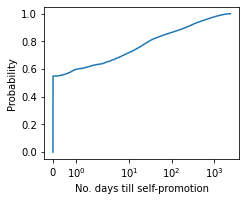

In [46]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5, 2.8))
# ax.hist(delta_days, bins = 30)
delta_days.sort()
delta_days = np.concatenate((delta_days, delta_days[[-1]]))
ax.step(delta_days, np.arange(1, delta_days.size+1)/float(delta_days.size))
ax.set_xlabel('No. days till self-promotion')
ax.set_ylabel(r'Probability')
ax.set_xscale('symlog')
plt.show()
fig.savefig('./self_promo_days_cdf.pdf', bbox_inches='tight', pad_inches=0.01)

Perc. of active obs on Tw

In [64]:
for gender, sub in reg_data.groupby('gender'):
    print(gender, np.mean(sub['is_active_on_twitter'] == True))

Female 0.04589395501347608
Male 0.05887708513598103


### Author-level analysis in raw data

In [17]:
len(set(reg_data.author_id))

3503674

In [44]:
tem = dict(Counter(dict(zip(reg_data['author_id'], reg_data['gender'])).values()))

In [45]:
tem

{'Male': 2029762, 'Female': 1473912}

In [46]:
# Frac of males
tem['Male'] / (tem['Male'] + tem['Female'])

0.5793238754518828

In [47]:
tem['Female'] / (tem['Male'] + tem['Female'])

0.4206761245481172

In [19]:
# percentage of authors in each gender who have ever self-promoted

for lab, gender, color in zip(labels, gens, colors):
    sub_df = reg_data.loc[reg_data['gender'] == gender, ['author_id', 'author_self_promotion_rate']]
    sub_df = sub_df.drop_duplicates()
    print(lab, np.mean(sub_df['author_self_promotion_rate'] > 0))

Man 0.08977321348042058
Woman 0.06111385508410185


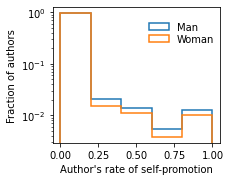

In [44]:
fig, ax = plt.subplots(figsize = (3, 2.5))

for lab, gender, color in zip(labels, gens, colors):
    sub_df = reg_data.loc[reg_data['gender'] == gender, ['author_id', 'author_self_promotion_rate']]
    sub_df = sub_df.drop_duplicates()
    n = len(sub_df)
    ax.hist(sub_df['author_self_promotion_rate'].tolist(), bins = 5, alpha=1, linewidth=1.5, \
            color=color, label=lab, histtype='step', weights=np.ones(n)/n)
# ax.set_ylabel('Number of authors')
ax.set_ylabel('Fraction of authors')
ax.set_xlabel("Author's rate of self-promotion")
ax.set_yscale('log')
legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('gender_rate_hist_all_authors.pdf', bbox_inches='tight', pad_inches=0.02)

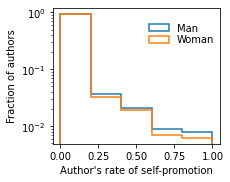

In [45]:
fig, ax = plt.subplots(figsize = (3, 2.5))

for lab, gender, color in zip(labels, gens, colors):
    mask = (reg_data['gender'] == gender) & (reg_data['author_num_papers_in_data'] >= 5)
    sub_df = reg_data.loc[mask, ['author_id', 'author_self_promotion_rate']]
    sub_df = sub_df.drop_duplicates()
    n = len(sub_df)
    ax.hist(sub_df['author_self_promotion_rate'].tolist(), bins = 5, alpha=1, linewidth=1.5, \
            color=color, label=lab, histtype='step', weights=np.ones(n)/n)
# ax.set_ylabel('Number of authors')
ax.set_ylabel('Fraction of authors')
ax.set_xlabel("Author's rate of self-promotion")
ax.set_yscale('log')
legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('gender_rate_hist_authors_5.pdf', bbox_inches='tight', pad_inches=0.02)

### Paper-level analysis in raw data

In [85]:
# original and retweets
tid_name = {}

with open(Data_Root+'tweets_v2.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid = line['id_str']
        tid_name[tid] = line['user']['name']
        
with open(Data_Root+'tweets_v2_non_full_text.json', 'r') as ifile:
    for line in ifile:
        line = json.loads(line)
        tid = line['id_str']
        tid_name[tid] = line['user']['name']

In [86]:
len(tid_name)

77497304

In [92]:
dois = set(reg_data.doi)

doi_tids = {}
with open(Data_Root+'revision/papers_2013_2018.json', 'r') as ifile:
    for line in ifile:
        res = json.loads(line)
        if res['doi'] in dois:
            doi_tids[res['doi']] = [tweet['tweet_id'] for tweet in res['data']['tweets'] if tweet['tweet_id'] in tid_name]
del dois

In [93]:
len(doi_tids)

2834829

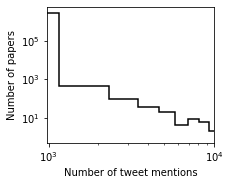

In [94]:
fig, ax = plt.subplots(figsize = (3, 2.5))

ax.hist([len(doi_tids[doi]) for doi in doi_tids], bins = 30, color='k', alpha=1, linewidth=1.5, histtype='step')
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of tweet mentions')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(right=1e4)
# legend = ax.legend(loc=[0.55, 0.7], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)
plt.show()
fig.savefig('./paper_tweets_hist.pdf', bbox_inches='tight', pad_inches=0.02)

Popularity

In [95]:
doi_frac_self_promo = []
for doi, sub_df in reg_data.groupby('doi'):
    total = len(doi_tids[doi])
    if total > 0:
        promo_users = set([tid_name[str(tid)] for tid in sub_df.loc[sub_df.self_promotion == True]['matched_tid']])
        num_self_promo = 0
        for tid in doi_tids[doi]:
            if tid_name[tid] in promo_users:
                num_self_promo += 1
        doi_frac_self_promo.append((doi, total, num_self_promo))

In [96]:
len(doi_frac_self_promo)

2046732

In [97]:
np.mean([num_self_promo/total for doi, total, num_self_promo in doi_frac_self_promo if total > 0])

0.04367299188803496

In [98]:
for i in range(0, 101, 10):
    tem = []
    for doi, total, num_self_promo in doi_frac_self_promo:
        if total > i and total <= (i+10):
            tem.append(num_self_promo/total)
    print("%d < x <= %d"%(i, i+10), np.mean(tem), np.median(tem))

0 < x <= 10 0.042127076550066006 0.0
10 < x <= 20 0.055990710812375985 0.0
20 < x <= 30 0.053717550649167084 0.0
30 < x <= 40 0.051178454860133525 0.02631578947368421
40 < x <= 50 0.04806262710830598 0.021739130434782608
50 < x <= 60 0.04523749933032134 0.018518518518518517
60 < x <= 70 0.04237157211533122 0.015873015873015872
70 < x <= 80 0.04286691107962363 0.013888888888888888
80 < x <= 90 0.04117621429600945 0.022222222222222223
90 < x <= 100 0.038804285951398475 0.020202020202020204
100 < x <= 110 0.040295779149073604 0.018691588785046728


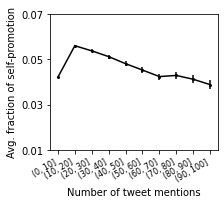

In [104]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3, 2.5))


xs, ys, confs = [], [], []

step = 10
for i in range(0, 91, step):
    xs.append(i)
    tem = []
    for doi, total, num_self_promo in doi_frac_self_promo:
        if total > i and total <= (i+step):
            tem.append(num_self_promo/total)
    ys.append(np.mean(tem))
    confs.append(CIs['95'] * np.std(tem) / np.sqrt(len(tem)))
                    
ax.errorbar(xs, ys, yerr=confs, color='k', fmt='-o', markersize=2, linewidth=1.5)
ax.set_yticks([0.01, 0.03, 0.05, 0.07, 0.09])
ax.set_xticks(xs)
ax.set_xticklabels(['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]'])
for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(30)
ax.set_xlabel('Number of tweet mentions')
ax.set_ylabel('Avg. fraction of self-promotion')
ax.set_ylim([0.01, 0.07])

# plt.tight_layout()
plt.show()
fig.savefig('./avg_perc_promo_paper_tweets.pdf', bbox_inches='tight', pad_inches=0.01)


Percentage of non-zero DV

In [49]:
tem = reg_data[['doi', 'total_num_tweets']].drop_duplicates()

In [56]:
np.mean(tem['total_num_tweets'] > 0)

0.7219959299132329

In [54]:
np.mean(reg_data['total_num_tweets'] > 0)

0.7455487317790191

In [55]:
np.mean(reg_data['self_promotion'] > 0)

0.042171839836472706

Discipline

In [16]:
name_map = {'Social Sciences': 'Social_Sciences',
            'Life Sciences': 'Life_Sciences',
            'Health Sciences': 'Health_Sciences',
            'Physical Sciences': 'Physical_Sciences'}

In [19]:
for disc in name_map.values():
    tem = reg_data.loc[(reg_data[disc] == 1) & (reg_data['num_discs'] == 1)][['author_id', 'gender']].drop_duplicates(subset='author_id', keep='first')
    print(disc)
    print(tem['gender'].value_counts()/len(tem))
    print()

Social_Sciences
Male      0.540553
Female    0.459447
Name: gender, dtype: float64

Life_Sciences
Male      0.554934
Female    0.445066
Name: gender, dtype: float64

Health_Sciences
Male      0.546328
Female    0.453672
Name: gender, dtype: float64

Physical_Sciences
Male      0.686786
Female    0.313214
Name: gender, dtype: float64



In [22]:
reg_data['num_discs'] = np.sum(reg_data[name_map.values()], axis=1)

In [23]:
# focus on distinctive disciplines
for disc in name_map.values():
    tem = reg_data.loc[(reg_data[disc] == 1) & (reg_data['num_discs'] == 1)][['author_id', 'gender']].drop_duplicates(subset='author_id', keep='first')
    print(disc)
    print(tem['gender'].value_counts()/len(tem))
    print()

Social_Sciences
Male      0.535541
Female    0.464459
Name: gender, dtype: float64

Life_Sciences
Male      0.569658
Female    0.430342
Name: gender, dtype: float64

Health_Sciences
Male      0.564794
Female    0.435206
Name: gender, dtype: float64

Physical_Sciences
Male      0.724363
Female    0.275637
Name: gender, dtype: float64



In [101]:
xs, ys, confs = [], [], []
for disc in name_map:
    tem = []
    dois_ = set(reg_data.loc[reg_data[name_map[disc]] == 1]['doi'])
    for doi, total, num_self_promo in doi_frac_self_promo:
        if doi in dois_:
            tem.append(num_self_promo/total)
    xs.append(np.mean(tem))
    ys.append(disc)
    confs.append(CIs['95'] * np.std(tem) / np.sqrt(len(tem)))

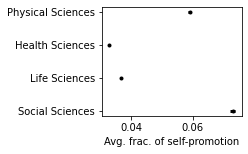

In [102]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5, 2))
ax.errorbar(xs, ys, xerr=confs, color='k', alpha=1, fmt='o', markersize=3, linewidth=3)
ax.set_xlabel('Avg. frac. of self-promotion')
plt.show()
fig.savefig('./avg_perc_promo_paper_disc.pdf', bbox_inches='tight', pad_inches=0.01)